# Code Challenge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

from keras_tuner import RandomSearch

# a) Generating a dataset. 

Use make_moons to simulate a data set: 
```python
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)
```
After you have generated it, check the shape, print out some rows of it and also do a plot: 

```python
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data generated by make_moons() function')
```

Text(0.5, 1.0, 'Data generated by make_moons() function')

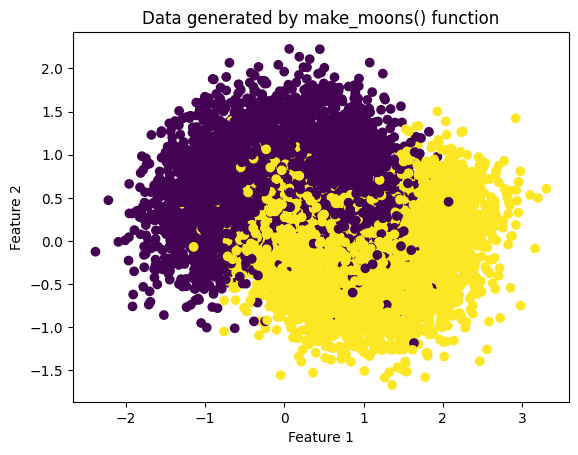

In [2]:
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data generated by make_moons() function')

In [3]:
# Inspecting our data
print(X.shape)
print(y.shape)

print()
print(y)
print()
print(X)

(10000, 2)
(10000,)

[1 0 0 ... 1 0 1]

[[ 0.9402914   0.12230559]
 [ 0.12454026 -0.42477546]
 [ 0.26198823  0.50841438]
 ...
 [-0.24177973  0.20957199]
 [ 0.90679645  0.54958215]
 [ 2.08837082 -0.05050728]]


In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1) 

# b) Now you will do some modelling from beginning to end meaning that you will have to decide how to split your data, what model to use and so on.
# Create 1 model with Scikit-learn. 
# Create 1 deep learning model. Try to tune hyperparameters with KerasTuner: https://keras.io/keras_tuner/ .
# Write down a short summary of your conclusions. 

## ML model with Scikit-learn

In [5]:
tree_clf = DecisionTreeClassifier(random_state=42)

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(tree_clf, params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [6]:
grid_search_cv.best_params_

{'max_leaf_nodes': 17, 'min_samples_split': 2}

# Visualizing classification results for DecisionTreeClassifier

In [7]:
results = grid_search_cv.predict(X_test)

In [8]:
pred=[]
for i in results:
    if i==0:
        pred.append('r')
    else:
        pred.append('g')
one_col=X_test[:,0]
two_col=X_test[:,1]
one_col,two_col

(array([ 0.7419761 ,  0.88454548,  1.07166065, ...,  0.81970951,
        -1.03931879,  1.51575915]),
 array([-0.69740484,  0.16201322,  0.06125565, ...,  0.33035055,
         0.09810193,  1.09687136]))

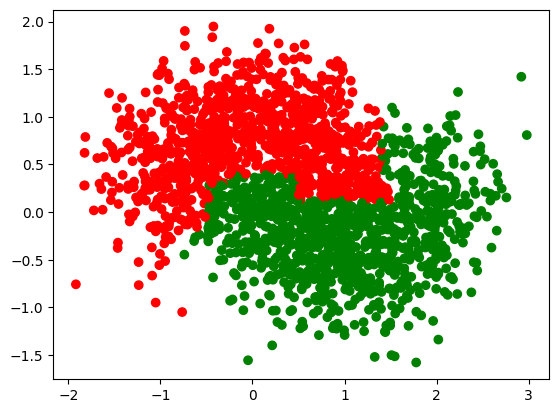

In [9]:
plt.scatter(x=one_col,y=two_col,c=pred)

## Neural Network model with Keras

In [10]:
n_cols = X_train.shape[1]

nn_model = Sequential()
nn_model.add(Dense(100, activation = 'relu', input_shape = (n_cols, )))
nn_model.add(Dropout(rate=0.2))
nn_model.add(Dense(50, activation = 'relu'))
nn_model.add(Dense(1, activation = 'sigmoid'))

In [11]:
nn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
early_stopping_monitor = EarlyStopping(patience = 5)
nn_model.fit(X_train, y_train, validation_split = 0.2, epochs = 100, callbacks = [early_stopping_monitor], verbose = False)

# Visualizing results for Neural network prediciton

In [13]:
nn_results = nn_model.predict(X_test)

63/63 [==============================] - 0s 742us/step


In [18]:
nn_pred=[]
for i in nn_results:
    if i>0.5: 
        nn_pred.append('r')
    else:
        nn_pred.append('g')
nn_one_col=X_test[:,0]
nn_two_col=X_test[:,1]

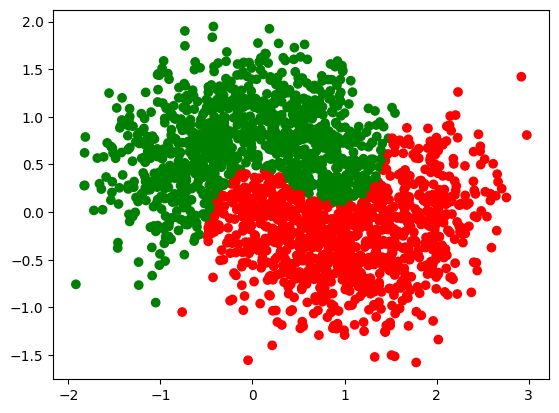

In [19]:
plt.scatter(x=nn_one_col,y=nn_two_col,c=nn_pred)

## Neural network, choosing hyperparameters with KerasTuner

In [11]:
def build_model(hp):
    n_cols = X_train.shape[1]
    nn_model = keras.Sequential()
    
    # Tune the number of units in the first dense layer
    hp_units_1 = hp.Int('units_1', min_value=30, max_value=200, step=10)
    nn_model.add(Dense(units=hp_units_1, activation='relu', input_shape=(n_cols,)))
    
    # Tune whether to use dropout.
    if hp.Boolean("dropout_1"):
    # Tune the dropout rate
        hp_dropout_rate = hp.Choice('dropout_rate_1', values=[i * 0.05 for i in range(12)])
        nn_model.add(Dropout(rate=hp_dropout_rate))
    
    # Tune the number of units in the second dense layer
    hp_units_2 = hp.Int('units_2', min_value=10, max_value=220, step=10)
    nn_model.add(Dense(units=hp_units_2, activation='relu'))
    
    # Tune whether to use dropout.
    if hp.Boolean("dropout_2"):
    # Tune the dropout rate
        hp_dropout_rate = hp.Choice('dropout_rate_2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
        nn_model.add(Dropout(rate=hp_dropout_rate))
    
    # Tune number of layers
    for i in range(hp.Int("num_layers", 1, 3)):
        nn_model.add(Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i+2}", min_value=10, max_value=150, step=5),
                activation='relu')) 
    
    nn_model.add(Dense(1, activation='sigmoid'))
    
    nn_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
    
    return nn_model


In [12]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10, 
    overwrite=True,
)

In [13]:
# tuner.search_space_summary()

In [14]:
# tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=3, callbacks=[early_stopping_monitor], verbose=2)
tuner.search(X_train, y_train, validation_split=0.2, epochs=3, callbacks=[early_stopping_monitor], verbose=2)

Trial 10 Complete [00h 00m 02s]
val_accuracy: 0.8203125

Best val_accuracy So Far: 0.846875011920929
Total elapsed time: 00h 00m 20s


In [15]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
units_1: 160
dropout_1: True
units_2: 160
dropout_2: False
num_layers: 3
dropout_rate_1: 0.45
units_3: 10
units_4: 10
Score: 0.846875011920929

Trial 08 summary
Hyperparameters:
units_1: 80
dropout_1: False
units_2: 160
dropout_2: False
num_layers: 2
dropout_rate_1: 0.2
units_3: 55
units_4: 15
dropout_rate_2: 0.2
Score: 0.846875011920929

Trial 02 summary
Hyperparameters:
units_1: 80
dropout_1: True
units_2: 130
dropout_2: True
num_layers: 2
dropout_rate_1: 0.4
units_3: 125
units_4: 40
dropout_rate_2: 0.0
Score: 0.8453124761581421

Trial 03 summary
Hyperparameters:
units_1: 170
dropout_1: True
units_2: 90
dropout_2: True
num_layers: 2
dropout_rate_1: 0.45
units_3: 150
units_4: 90
dropout_rate_2: 0.0
Score: 0.8453124761581421

Trial 05 summary
Hyperparameters:
units_1: 130
dropout_1: True
units_2: 20
dropout_2: True
num_layers: 3
dropout

In [16]:
# Get the top 2 models.
tuned_nn = tuner.get_best_models(num_models=2)[0]
tuned_nn.build()

In [17]:
tuned_nn.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping_monitor], verbose=False)

# Comparing models in validation data

### Evaluating our Sklearn model

In [18]:
tree_pred_val = grid_search_cv.predict(X_val)
tree_pred_val

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [19]:
tree_pred_val.shape

(1600,)

In [20]:
accuracy_score(y_val, tree_pred_val)

0.85375

### Evaluating our simple nn

In [21]:
nn_pred_val = nn_model.predict(X_val)

# Returns probabilities
print(nn_pred_val)

50/50 [==============================] - 0s 633us/step
[[0.19639003]
 [0.04646696]
 [0.61401886]
 ...
 [0.00313782]
 [0.99676204]
 [0.65640426]]


In [22]:
# Transforming to predicted classes instead of probabilities

# https://stackoverflow.com/questions/68776790/model-predict-classes-is-deprecated-what-to-use-instead
threshold = 0.5
nn_pred_val_label = np.where(nn_pred_val > threshold, 1,0)

print(nn_pred_val_label)

[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [1]]


In [23]:
accuracy_score(y_val, nn_pred_val_label)

0.845625

### Evaluating our tuned Neural Network

In [24]:
tuned_nn_pred_val = tuned_nn.predict(X_val)
print(tuned_nn_pred_val)

50/50 [==============================] - 0s 878us/step
[[0.18500422]
 [0.00999096]
 [0.6292729 ]
 ...
 [0.00473624]
 [0.9813176 ]
 [0.6684159 ]]


In [25]:
threshold = 0.5
tuned_nn_pred_val_label = np.where(tuned_nn_pred_val > threshold, 1,0)
print(tuned_nn_pred_val_label)

[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [1]]


In [26]:
accuracy_score(y_val, tuned_nn_pred_val_label)

0.845625

# Refitting our model on the train and validation data before evaluating it on the test data

In [27]:
best_model = grid_search_cv.best_estimator_.fit(X_train_val, y_train_val)

In [28]:
test_predictions = best_model.predict(X_test)

In [29]:
accuracy_score(y_test, test_predictions)

0.8465